In [11]:
import sys
import os

current_path = os.path.abspath('')
parent_path = os.path.dirname(current_path)

if parent_path not in sys.path:
    sys.path.insert(0, parent_path)

import csv
import itertools
import matplotlib.pyplot as plt

from smoother import ConstantTerm, LinearTerm, DistanceWeighting, SpatialWeightSmoother
from gass import GASS

import matplotlib.pyplot as plt
import seaborn as sns

# Functions

In [38]:
# Compute the error term's standard deviation with p*100 % noise levels
def error_term_sdd(y_fitted, p):
    # Calculate variance of y_fitted
    var_systematic = np.var(y_fitted)
    
    # Calculate variance of error term using the derived formula
    var_error = p * var_systematic / (1-p)
    
    # Return standard deviation of the error term
    return np.sqrt(var_error)

In [39]:
# Classic Backfitting
from spglm.iwls import _compute_betas_gwr
from mgwr.search import golden_section

def classic_backfit(y, X, w, term_mapping, verbose = False, max_iter = 50, tol = 1e-8):
    n,k = X.shape
    betas = _compute_betas_gwr(y, X, w.reshape((-1, 1)))[0]
    XB = np.multiply(betas.T, X)
    yhat = np.dot(X, betas)
    err = y.reshape((-1, 1)) - yhat
    scores = []
    delta = 1e6
    
    sigs = [-1, -1]

    for n_iter in range(1, max_iter + 1):
        new_XB = np.zeros_like(X)
        params = np.zeros_like(betas)

        for j in range(k):

            temp_y = XB[:, j].reshape((-1, 1))
            temp_y = temp_y + err.reshape((-1, 1))
            temp_X = X[:, j].reshape((-1, 1))
            type_name, term_instance = term_mapping[j]  

            if type_name not in ['LinearTerm', 'ConstantTerm']:
                gscr = lambda x: sm.OLS(y, np.hstack((term_instance.cal(x)))).fit().aic
                sig = golden_section(term_instance.lower_bound, term_instance.upper_bound, 0.3879, gscr, 1e-2, 50, 50)[0]
                sigs[j-1] = sig
                sv = term_instance.cal(sig) # new smoothed values
                X[:, j] = sv.flatten()
                temp_X = sv.flatten().reshape((-1,1))

            beta = _compute_betas_gwr(temp_y, temp_X, w.reshape((-1,1)))[0]
            yhat = np.dot(temp_X, beta)
            new_XB[:, j] = yhat.flatten()
            err = (temp_y - yhat).reshape((-1, 1))
            params[j, :] = beta[0][0]

        num = np.sum((XB-new_XB)**2)
        den = 1 + np.sum(np.sum(XB, axis=1)**2)
        score = (num / den)
        XB = new_XB

        scores.append(deepcopy(score))
        delta = score

        if verbose:
            print("Current iteration:", n_iter, ",SOC:", np.round(score, 8))
        if delta < tol:
            break

    return params, X, sigs

def calibrate_Gaussian(y, X, term_mapping, verbose = False, max_iter = 50, crit_threshold = 1e-8):
    
    X = X.copy()
    y = y.copy()

    sigmas = [-1, -1]

    s_0 = np.mean(y)
    eta = s_0.reshape((-1, 1))
    s_old = np.ones_like(X)
    crit = 9999
    n_iter = 0

    while crit > crit_threshold and n_iter < max_iter:
        w = np.ones(X.shape[0])
        z = y.reshape((-1, 1))
        betas, X, sigmas = classic_backfit(z, X, w, term_mapping = term_mapping, verbose = verbose, max_iter = max_iter, tol = crit_threshold) 

        s_new = np.multiply(betas.T, X)
        inner = np.sum((s_old - s_new)**2, axis=1)
        num = np.sum(w*inner)
        den = np.sum(w*np.sum((1 + s_old)**2, axis=1).reshape((-1, 1)))
        crit = num / den
        eta = np.sum(s_new, axis=1).reshape((-1, 1))
        s_old = s_new

        n_iter += 1  # increment the iteration counter
    return betas, sigmas

In [40]:
def format_sigma_for_filename(sigma):
    """
    Format the sigma values to be used in the filename.
    - Remove the negative sign.
    - Replace the decimal point with 'pt'.
    - Do not include the leading zero if the absolute value is less than 1.
    - Do not include trailing zeros after the decimal point.
    """
    # Convert sigma to a positive number and create a formatted string
    formatted_sigma = '{:.2f}'.format(abs(sigma)).lstrip('0').replace('.', 'pt').rstrip('pt0')
    
    return formatted_sigma

In [45]:
def simulate_and_write_results_classic(sigma1, sigma2):

    # Convert sigma1 and sigma2 to a string suitable for the filename
    sigma1_str = format_sigma_for_filename(sigma1)
    sigma2_str = format_sigma_for_filename(sigma2)
    filename = f"../results/appendix/0%Noise_classic_{sigma1_str}_{sigma2_str}.csv"

    with open(filename, "a", newline='') as csvfile:
        writer = csv.writer(csvfile)

        # Check if file is empty and write headers
        if csvfile.tell() == 0:
            writer.writerow(["beta_x1", "beta_s_x2", "beta_s_pois", "sigma_s_x2", "sigma_s_pois"])

        # 1. Implement 100 Simulations
        n_iter = 0 # track iterations
        for i in range(100): # i is also the seed 
            # Spatial Systems
            np.random.seed(i)
            square = Polygon([Point((0, 0)), Point((0, 2000)), Point((2000, 2000)), Point((2000, 0))])
            squwin = as_window(square)

            # Stations
            np.random.seed(i)
            squsamples = PoissonPointProcess(squwin, 150, 1, conditioning=False, asPP=False)
            squpts_random = squsamples.realizations[0]

            # DataFrame for Stations
            random_df = pd.DataFrame(squpts_random, columns = ['Lon', 'Lat'])
            random_df = random_df.assign(Name = np.arange(random_df.shape[0]))
            digits = len(str(150))
            random_df.Name = random_df.Name.astype(str).str.zfill(digits).apply(lambda x: "{}{}".format('R', x))

            # Add attributes, X1 and X2, for Stations
            attr1 = np.random.uniform(2, 100, 150)
            attr2 = np.random.uniform(100, 500, 150)

            random_df = random_df.assign(X1 = attr1, X2 = attr2)

            # POIs
            np.random.seed(i * 2)
            squsamples_pois = PoissonPointProcess(squwin, 900, 1, conditioning=False, asPP=False)
            squpts_pois = squsamples_pois.realizations[0]

            # DataFrame for POIs
            pois_df = pd.DataFrame(squpts_pois, columns = ['Lon', 'Lat'])
            pois_df = pois_df.assign(Name = np.arange(pois_df.shape[0]))
            digits = len(str(900))
            pois_df.Name = pois_df.Name.astype(str).str.zfill(digits).apply(lambda x: "{}{}".format('I', x))

            # Add attribute for POIs
            attrI = np.ones(pois_df.shape[0])
            pois_df = pois_df.assign(AttributeI = attrI)

            # Necessary data for constructing `LinearTerm` of X1, and `DistanceWeighting` smoother of X2
            dta_simul = random_df[['Name', 'X1', 'X2']]
            dta_simul_gdf = random_df[['Name', 'Lon', 'Lat']]
            dta_simul_gdf = gpd.GeoDataFrame(dta_simul_gdf.copy(), geometry=gpd.points_from_xy(dta_simul_gdf.Lon, dta_simul_gdf.Lat))

            # Necessary data for constructing `DistanceWeighting` smoother of POIs
            pois_simul_df = pois_df[['Name', 'AttributeI']]
            pois_simul_gdf = pois_df[['Name', 'Lon', 'Lat']]
            pois_simul_gdf = gpd.GeoDataFrame(pois_simul_gdf.copy(), geometry=gpd.points_from_xy(pois_simul_gdf.Lon, pois_simul_gdf.Lat))
            map_simul_gdf = pd.concat([dta_simul_gdf, pois_simul_gdf]) # A map includes both the stations and POIs 

            # Construct spatial smoothers for X1, X2 and POIs
            lin_simul = LinearTerm(dta_simul, 1, standard = True) # X1
            iss_simul_X2 = iSpatialSmoother(dta_simul, dta_simul_gdf, [0,0,2], standard = True) # smoothing X2
            dw_simul_pois = DistanceWeighting(dta_simul, map_simul_gdf, pois_simul_df, [0,0,0,1], standard = True)# smoothing POI
            iss_simul_X2.set_searching_range(-3, -0.1)
            dw_simul_pois.set_searching_range(-3, -0.1)

            # Set the true values of distance decay parameters using the function arguments
            s_X2_simul = iss_simul_X2.cal(sigma1) # Use sigma1 here
            s_POIs_simul = dw_simul_pois.cal(sigma2) # Use sigma2 here

            # Set the true values of coefficients for X1, s(X2), and s(POIs)
            coefs_simul = [1,1,1] 

            # Generate y with adding 5% noise 
            np.random.seed(i)
            X_simul = np.hstack((lin_simul.X, s_X2_simul, s_POIs_simul)) 
            y_fitted = np.dot(X_simul, coefs_simul).reshape(-1,1)
            # y_simul = y_fitted + np.random.normal(0, error_term_sdd(y_fitted, 0.05), (dta_simul.shape[0],1)).reshape(-1,1) # 0.05: 5%

            # Fit calssic backfitting model
            term_mapping = {}
            term_mapping [0] = (type(lin_simul).__name__, lin_simul)  
            term_mapping [1] = (type(iss_simul_X2).__name__, iss_simul_X2)   
            term_mapping [2] = (type(dw_simul_pois).__name__, dw_simul_pois)  

            initial_X_simul = np.hstack((lin_simul.X, iss_simul_X2.cal(-1), dw_simul_pois.cal(-1)))

            coefs, sigs = calibrate_Gaussian(y_fitted, initial_X_simul, term_mapping)

            # Store results
            beta_x1 = pd.to_numeric(coefs[0].item())
            beta_s_x2 = pd.to_numeric(coefs[1].item())
            beta_s_pois = pd.to_numeric(coefs[2].item())
            sigma_s_x2 = pd.to_numeric(sigs[0].item())
            sigma_s_pois = pd.to_numeric(sigs[1].item())
            #print(beta_x1, beta_s_x2, beta_s_pois, sigma_s_x2, sigma_s_pois)
 
            writer.writerow([beta_x1, beta_s_x2, beta_s_pois, sigma_s_x2, sigma_s_pois])

In [46]:
def simulate_and_write_results_modified(sigma1, sigma2):
    # Convert sigma1 and sigma2 to a string suitable for the filename
    sigma1_str = format_sigma_for_filename(sigma1)
    sigma2_str = format_sigma_for_filename(sigma2)
    filename = f"../results/appendix/0%Noise_{sigma1_str}_{sigma2_str}.csv"
    
    with open(filename, "a", newline='') as csvfile:
        writer = csv.writer(csvfile)
        
        # Check if file is empty and write headers
        if csvfile.tell() == 0:
            writer.writerow(["beta_x1", "beta_s_x2", "beta_s_pois", "sigma_s_x2", "sigma_s_pois"])
        
        # 1. Implement 100 Simulations
        n_iter = 0 # track iterations
        for i in range(100): # i is also the seed 
            # Spatial Systems
            np.random.seed(i)
            square = Polygon([Point((0, 0)), Point((0, 2000)), Point((2000, 2000)), Point((2000, 0))])
            squwin = as_window(square)

            # Stations
            np.random.seed(i)
            squsamples = PoissonPointProcess(squwin, 150, 1, conditioning=False, asPP=False)
            squpts_random = squsamples.realizations[0]

            # DataFrame for Stations
            random_df = pd.DataFrame(squpts_random, columns = ['Lon', 'Lat'])
            random_df = random_df.assign(Name = np.arange(random_df.shape[0]))
            digits = len(str(150))
            random_df.Name = random_df.Name.astype(str).str.zfill(digits).apply(lambda x: "{}{}".format('R', x))

            # Add attributes, X1 and X2, for Stations
            attr1 = np.random.uniform(2, 100, 150)
            attr2 = np.random.uniform(100, 500, 150)

            random_df = random_df.assign(X1 = attr1, X2 = attr2)

            # POIs
            np.random.seed(i * 2)
            squsamples_pois = PoissonPointProcess(squwin, 900, 1, conditioning=False, asPP=False)
            squpts_pois = squsamples_pois.realizations[0]

            # DataFrame for POIs
            pois_df = pd.DataFrame(squpts_pois, columns = ['Lon', 'Lat'])
            pois_df = pois_df.assign(Name = np.arange(pois_df.shape[0]))
            digits = len(str(900))
            pois_df.Name = pois_df.Name.astype(str).str.zfill(digits).apply(lambda x: "{}{}".format('I', x))

            # Add attribute for POIs
            attrI = np.ones(pois_df.shape[0])
            pois_df = pois_df.assign(AttributeI = attrI)

            # Necessary data for constructing `LinearTerm` of X1, and `DistanceWeighting` smoother of X2
            dta_simul = random_df[['Name', 'X1', 'X2']]
            dta_simul_gdf = random_df[['Name', 'Lon', 'Lat']]
            dta_simul_gdf = gpd.GeoDataFrame(dta_simul_gdf.copy(), geometry=gpd.points_from_xy(dta_simul_gdf.Lon, dta_simul_gdf.Lat))

            # Necessary data for constructing `DistanceWeighting` smoother of POIs
            pois_simul_df = pois_df[['Name', 'AttributeI']]
            pois_simul_gdf = pois_df[['Name', 'Lon', 'Lat']]
            pois_simul_gdf = gpd.GeoDataFrame(pois_simul_gdf.copy(), geometry=gpd.points_from_xy(pois_simul_gdf.Lon, pois_simul_gdf.Lat))
            map_simul_gdf = pd.concat([dta_simul_gdf, pois_simul_gdf]) # A map includes both the stations and POIs 

            # Construct spatial smoothers for X1, X2 and POIs
            lin_simul = LinearTerm(dta_simul, 1, standard = True) # X1
            iss_simul_X2 = iSpatialSmoother(dta_simul, dta_simul_gdf, [0,0,2], standard = True) # smoothing X2
            dw_simul_pois = DistanceWeighting(dta_simul, map_simul_gdf, pois_simul_df, [0,0,0,1], standard = True)# smoothing POI
            iss_simul_X2.set_searching_range(-3, -0.1)
            dw_simul_pois.set_searching_range(-3, -0.1)

            # Set the true values of distance decay parameters using the function arguments
            s_X2_simul = iss_simul_X2.cal(sigma1) # Use sigma1 here
            s_POIs_simul = dw_simul_pois.cal(sigma2) # Use sigma2 here

            # Set the true values of coefficients for X1, s(X2), and s(POIs)
            coefs_simul = [1,1,1] 

            # Generate y with adding 5% noise 
            np.random.seed(i)
            X_simul = np.hstack((lin_simul.X, s_X2_simul, s_POIs_simul)) 
            y_fitted = np.dot(X_simul, coefs_simul).reshape(-1,1)
            
            # Fit GASS model
            gass_simul = GASS(y_fitted, lin_simul, iss_simul_X2, dw_simul_pois, constant = False)
            gass_simul.fit_Gaussian()

            # Store results
            beta_x1 = pd.to_numeric(gass_simul.coefficients[0].item())
            beta_s_x2 = pd.to_numeric(gass_simul.coefficients[1].item())
            beta_s_pois = pd.to_numeric(gass_simul.coefficients[2].item())
            sigma_s_x2 = pd.to_numeric(gass_simul.sigmas[0].item())
            sigma_s_pois = pd.to_numeric(gass_simul.sigmas[1].item())
            
            writer.writerow([beta_x1, beta_s_x2, beta_s_pois, sigma_s_x2, sigma_s_pois])

# Repeated Simulations Without Noise for Different Combinations of Sigmas

In [48]:
array1 = [-0.5, -0.6, -0.7, -0.8, -0.9, -1.0]
array2 = [-1.1, -1.2, -1.3, -1.4, -1.5, -1.6]

# Create all possible pairs using itertools.product
combinations = list(itertools.product(array1, array2))

# Round each element in the pairs to two decimal places
combinations = [(round(a, 2), round(b, 2)) for (a, b) in combinations]

# If you also want pairs where the elements are reversed, you can add those manually
combinations_with_reverse = combinations + [(b, a) for (a, b) in combinations]

# Open a text file to append the error messages
with open('../results/temporary2/0%Noise_simulation.txt', 'a') as error_file:
    for idx, sigs_combo in enumerate(combinations_with_reverse):
        sig1 = sigs_combo[0]
        sig2 = sigs_combo[1]
        
        # Write the processed signals to the file as well
        process_message = f"Processed sigmas: {sig1}, {sig2}\n"
        error_file.write(process_message)
        
        try:
            simulate_and_write_results_classic(sig1, sig2)
        except Exception as e:
            error_message = f"An error occurred in classic: {e}\n"
            error_file.write(error_message)
        
        try:
            simulate_and_write_results_modified(sig1, sig2)
        except Exception as e:
            error_message = f"An error occurred in modified: {e}\n"
            error_file.write(error_message)
        
        print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71


In [50]:
simulate_and_write_results_modified(-0.5, -1.0)
simulate_and_write_results_classic(-0.5, -1.0)
simulate_and_write_results_modified(-1.0, -0.5)
simulate_and_write_results_classic(-1.0, -0.5)

# Plot

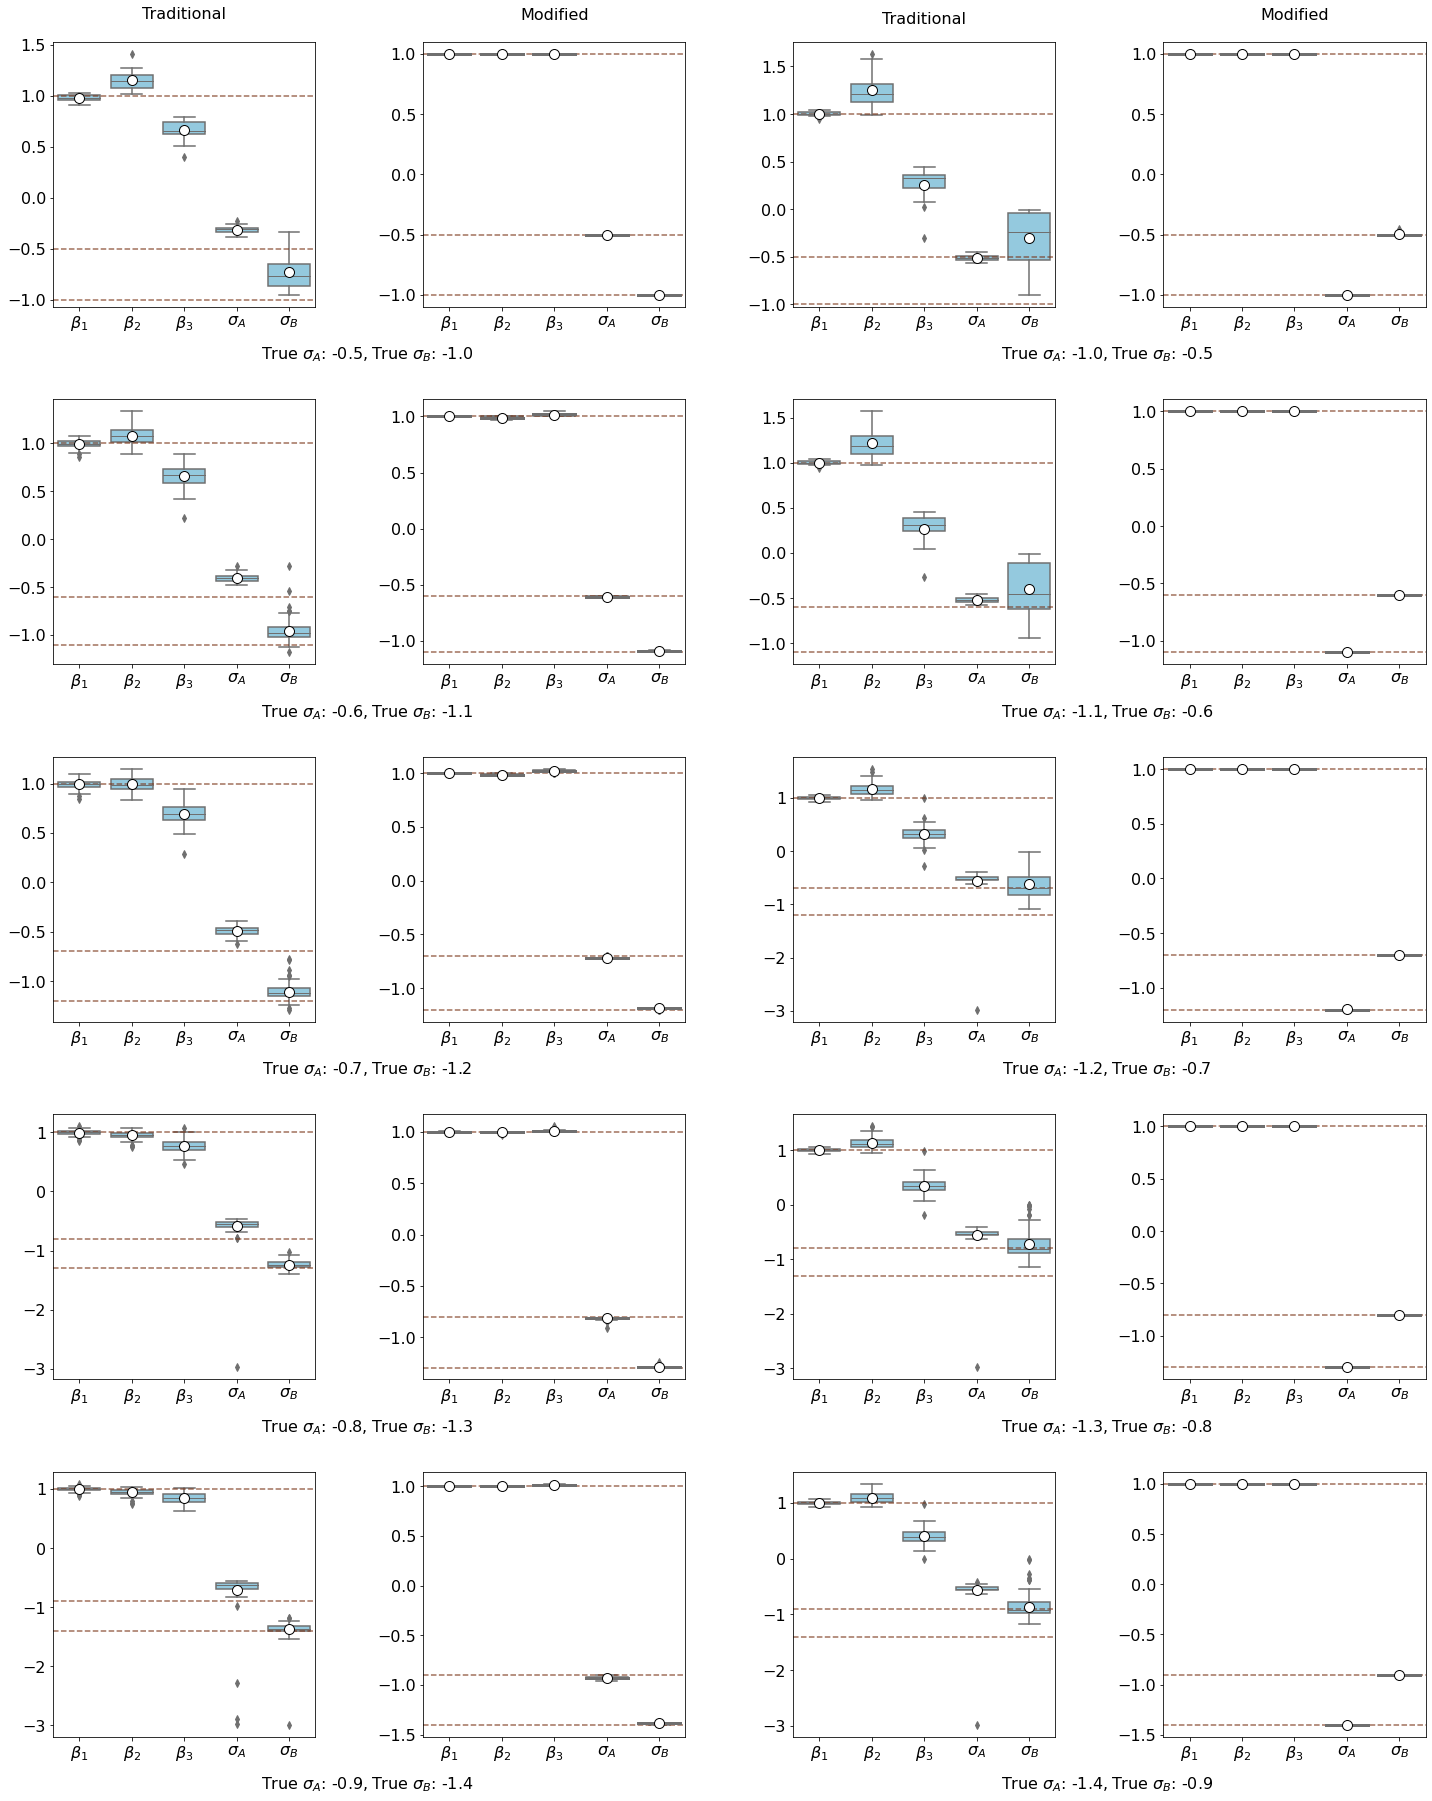

In [51]:
# Define your sigma value pairs
first_group = [[-0.5, -1.0], [-1.0, -0.5], [-0.6, -1.1], [-1.1, -0.6], [-0.7, -1.2]]
second_group = [[-1.2, -0.7], [-0.8, -1.3], [-1.3, -0.8], [-0.9, -1.4], [-1.4, -0.9]]

# Combine the two groups for plotting
sigma_combinations = first_group + second_group

labels = [r"$\beta_{1}$", r"$\beta_{2}$", r"$\beta_{3}$", r"$\sigma_{A}$", r"$\sigma_{B}$"]

fig = plt.figure(figsize=(20, 25))

for idx, (sig1, sig2) in enumerate(sigma_combinations):
    
    row, pair_idx = divmod(idx, 2)
    col = pair_idx * 2  # Each pair occupies two columns

    # Create two subplots in each cell of the 4x5 grid
    ax1 = fig.add_subplot(5, 4, row * 4 + col + 1)
    ax2 = fig.add_subplot(5, 4, row * 4 + col + 2)
    
    ax1.text(1.2, -0.18, f"True $\\sigma_A$: {sig1},", ha='right', va='center', transform=ax1.transAxes, fontsize=16)
    ax2.text(-0.2, -0.18, f"True $\\sigma_B$: {sig2}", ha='left', va='center',  transform=ax2.transAxes, fontsize=16)

    # Format the sigma values for filenames
    sigma1_str = format_sigma_for_filename(sig1)
    sigma2_str = format_sigma_for_filename(sig2)
    
    # Construct the filenames
    filename1 = f"../results/no_noise/0%Noise_classic_{sigma1_str}_{sigma2_str}.csv"
    filename2 = f"../results/no_noise/0%Noise_{sigma1_str}_{sigma2_str}.csv"
    
    # Read the data
    df_0_classic = pd.read_csv(filename1)
    df_0_modified = pd.read_csv(filename2)

    # Plot the classic data on the left subplot
    sns.boxplot(x="variable", y="value",data=pd.melt(df_0_classic), ax=ax1, showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"},
            medianprops = {"linewidth": 1},
            color = 'skyblue')
    
    ax1.axhline(y=1.0, color='#783114', linestyle='--', linewidth=1.5, alpha=0.7)
    ax1.axhline(y=sig1, color='#783114', linestyle='--', linewidth=1.5, alpha=0.7)
    ax1.axhline(y=sig2, color='#783114', linestyle='--', linewidth=1.5, alpha=0.7)
    
    ax1.tick_params(axis='y', labelsize=14)
    ax1.set_xticklabels(labels,fontsize=14)
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax1.tick_params(axis='both', labelsize=16)
    
    # Plot the modified data on the right subplot
    sns.boxplot(x="variable", y="value",data=pd.melt(df_0_modified), ax=ax2, showmeans=True,
        meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"},
        medianprops = {"linewidth": 3},
        color = 'skyblue')
    
    ax2.axhline(y=1.0, color='#783114', linestyle='--', linewidth=1.5, alpha=0.7)
    ax2.axhline(y=sig1, color='#783114', linestyle='--', linewidth=1.5, alpha=0.7)
    ax2.axhline(y=sig2, color='#783114', linestyle='--', linewidth=1.5, alpha=0.7)
    
    ax2.tick_params(axis='y', labelsize=14)
    ax2.set_xticklabels(labels,fontsize=14)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.tick_params(axis='both', labelsize=16)
    
    if idx == 0 :
        ax1.text(2, 1.8, "Traditional", ha='center', va='center', fontsize=16)
        ax2.text(2, 1.32, "Modified", ha='center', va='center', fontsize=16)
    if idx == 1 :
        ax1.text(2, 2.0, "Traditional", ha='center', va='center', fontsize=16)
        ax2.text(2, 1.32, "Modified", ha='center', va='center', fontsize=16)

# Adjust the layout so that plots do not overlap
plt.tight_layout()
plt.subplots_adjust(hspace=0.35)

#plt.savefig("../results/appendix/different_sigmas.png", dpi = 300)
plt.show()
